In [2]:
import traceback
import yaml
import tweepy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import os
import tempfile
import imageio as iio
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('apikey.yml','r') as f:
    secret = yaml.safe_load(f.read())

consumer_key = secret['consumer_key']
consumer_secret = secret['consumer_secret_key']
access_token = secret['access_token']
access_token_secret = secret['access_token_secret']
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [4]:
def get_user_info(screen_name,res=None):
    user = api.get_user(screen_name=screen_name)
    if res == 'high':
        url = user.profile_image_url.replace('_normal.jpg','_400x400.jpg')
    else:
        url = user.profile_image_url
    profile_image = get_image(url)
    return user,profile_image

def get_image(profile_url):
    with tempfile.TemporaryDirectory() as tmpdirname:
        response = requests.get(profile_url)
        filepath = os.path.join(tmpdirname,'profile.jpg')
        if response.status_code == 200:
            with open(filepath,'wb') as f:
                f.write(response.content)
            image=iio.v3.imread(filepath)
            return image
        else:
            return None

In [4]:

# https://docs.tweepy.org/en/stable/api.html#tweepy.API.get_user
# API.get_user(*, user_id, screen_name, include_entities)

Stacy Herbert 🇸🇻 stacyherbert False Fairy godmother 🧚‍♂️ | Bitcoiner at @orangepillpod & @elzontecapital with @maxkeiser | Pronouns: VOLCANO BLONDE | My president is @nayibbukele 🇸🇻
(48, 48, 3)


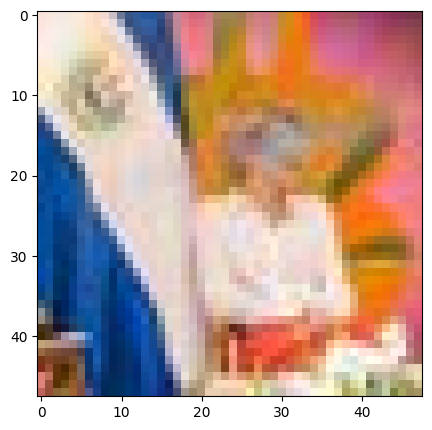

In [5]:
# @CaitlinLong_
screen_name = 'stacyherbert'
include_entities = True
user,profile_image = get_user_info(screen_name)

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

In [18]:
# https://docs.tweepy.org/en/stable/api.html?highlight=search_users#tweepy.API.search_users
# API.search_users(q, *, page, count, include_entities)
# 
# page – Specifies the page of results to retrieve. Note: there are pagination limits.
# count – The number of results to try and retrieve per page.

In [7]:
# set reference image and corresponding query using `user.name`

reference_screen_name = 'stacyherbert'
user,reference_image = get_user_info(screen_name)
query = user.name

user_name = user.name
query_list = [reference_screen_name,user_name]
query_list.extend(user.description.split('\n'))
print(query_list)

['stacyherbert', 'Stacy Herbert 🇸🇻', 'Fairy godmother 🧚\u200d♂️ | Bitcoiner at @orangepillpod & @elzontecapital with @maxkeiser | Pronouns: VOLCANO BLONDE | My president is @nayibbukele 🇸🇻']


In [8]:

# find  page_count*items_per_page count that matches the query
# API limit is 1k.
fetch = []
page_num = 10
count_per_page = 100
for query in query_list:
    try:
        for x in range(page_num):
            print(f'querying page {x}')
            tmp = api.search_users(query,count=count_per_page,page=x)
            fetch.extend(tmp)
            if len(tmp)<count_per_page:
                break
    except:
        traceback.print_exc()
    
print(len(fetch))

querying page 0
querying page 0
querying page 0
32


In [9]:
print(fetch[0])

User(_api=<tweepy.api.API object at 0x7fe451050af0>, _json={'id': 19062153, 'id_str': '19062153', 'name': 'Stacy Herbert 🇸🇻', 'screen_name': 'stacyherbert', 'location': 'On Air', 'description': 'Fairy godmother 🧚\u200d♂️ | Bitcoiner at @orangepillpod & @elzontecapital with @maxkeiser | Pronouns: VOLCANO BLONDE | My president is @nayibbukele 🇸🇻', 'url': 'https://t.co/xJdRC0k9qO', 'entities': {'url': {'urls': [{'url': 'https://t.co/xJdRC0k9qO', 'expanded_url': 'https://www.youtube.com/orangepill', 'display_url': 'youtube.com/orangepill', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 182737, 'friends_count': 2444, 'listed_count': 2632, 'created_at': 'Fri Jan 16 10:54:09 +0000 2009', 'favourites_count': 51753, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 150305, 'lang': None, 'status': {'created_at': 'Mon Oct 31 20:28:25 +0000 2022', 'id': 1587179707543523330, 'id_str': '1587179707543523330',

In [15]:
x = np.random.rand(10)
y = np.random.rand(10)
a=np.corrcoef(x,y)
print(a[0,1])

0.5311424658134071


In [33]:

import time
# try to find a match based on profile image
mylist = []
profile_cache = {}
user_cache = {}
for n,item in enumerate(fetch):
    try:
        user,profile_image = get_user_info(item.screen_name)
        # skip item if its reference
        if user.screen_name == reference_screen_name:
            continue
        # if http error skip
        if profile_image is None:
            profile_cache[user.screen_name]=None
            continue
        # compute only if shape matches
        if profile_image.shape == reference_image.shape:
            x = profile_image.ravel()
            y = reference_image.ravel()
            c=np.corrcoef(x,y)
            sim_val = c[0,1]
            print(sim_val)
            item = dict(screen_name=user.screen_name,sim_val=sim_val)
            profile_cache[user.screen_name]=profile_image.copy()
            user_cache[user.screen_name]=user
        else:
            item = dict(screen_name=user.screen_name,sim_val=np.nan)
            profile_cache[user.screen_name]=None
            user_cache[user.screen_name]=user
        mylist.append(item)
    except:
        traceback.print_exc()
        continue

df = pd.DataFrame(mylist)
print(df.shape)

0.005592361343675779
-0.2535524945381214
0.03498648697877379
0.325962129390827
0.07775959410451709
0.940741717322362
0.2652557195344054
-0.05400994554131032
0.9988249199489116
0.0006472296331800728
0.018472632324551153
-0.06258757737745464
0.9988701061894729
0.9988249199489116
-0.05479475648831902
0.24095175664985338
-0.008474125893361611
-0.02573694919308648
0.17452482238334743
0.9988701061894729
-0.008474125893361611
-0.0030803217993463964
-0.04932453336132376
0.15789945164886102
-0.040787432777342626
-0.008474125893361611
0.9988481312072532
-0.08500611289239376
0.23522832146196232
(29, 2)


In [34]:
df = df.sort_values('sim_val',ascending=False)

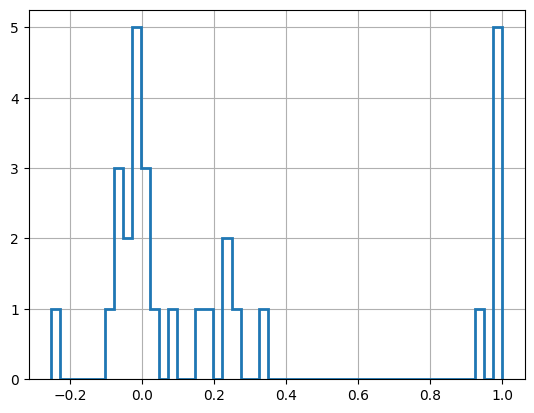

In [35]:
_=plt.hist(df.sim_val,bins=50,histtype='step',linewidth=2)
plt.grid(True)

In [36]:
df

,screen_name,sim_val
19,staceey_herbert,0.998870
12,stacyherrbbertt,0.998870
26,Stacyherberi,0.998848
8,ReinaGraham18,0.998825
13,stacyherberrt__,0.998825
5,sStacyherbert_,0.940742
3,PaintingBitcoin,0.325962
6,stacyherbert19,0.265256
15,xstacyherbert,0.240952
28,slherbert,0.235228


/tmp/ipykernel_14/2549012908.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(n,figsize=(3,3))


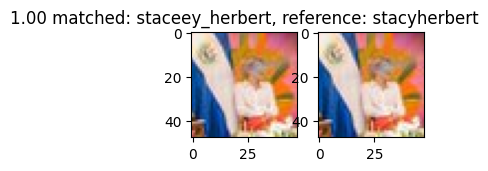

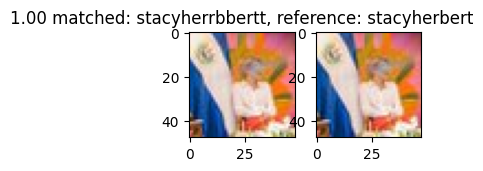

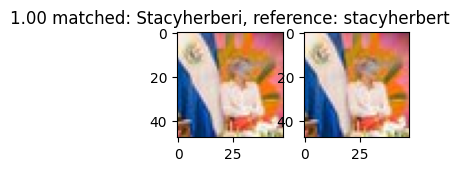

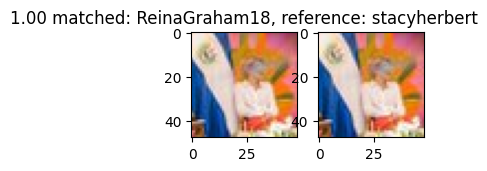

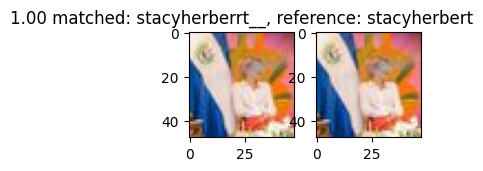

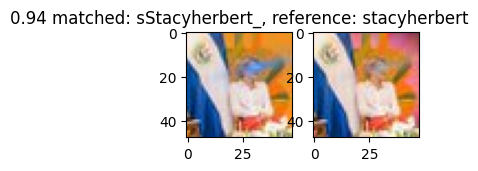

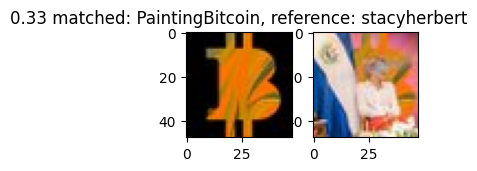

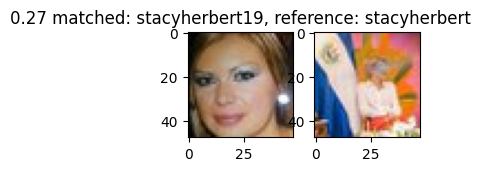

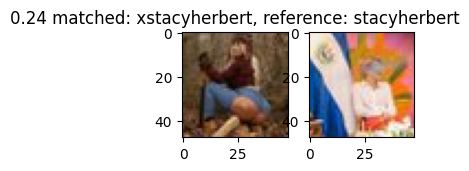

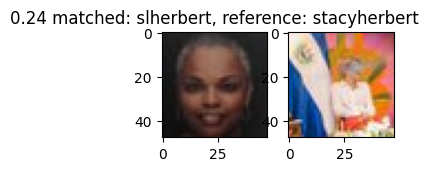

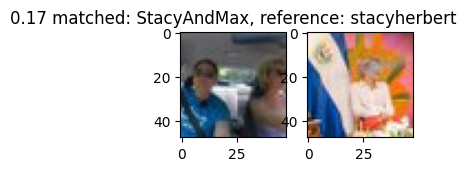

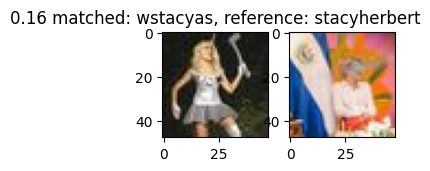

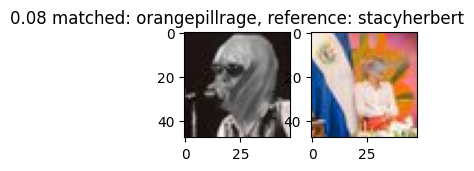

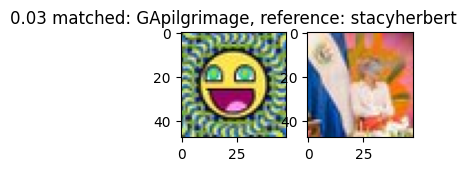

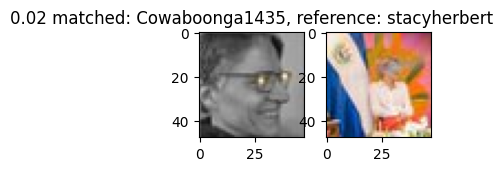

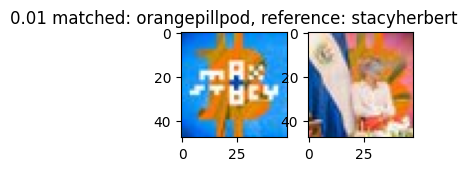

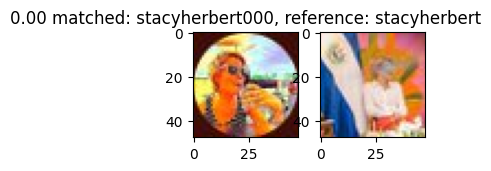

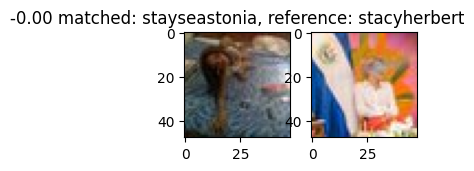

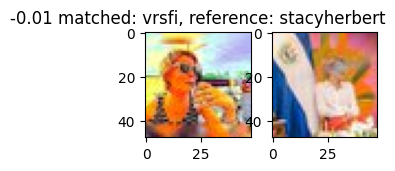

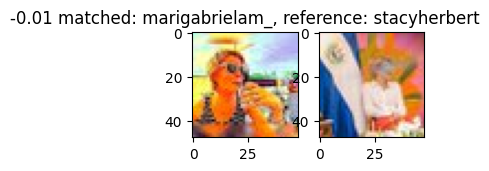

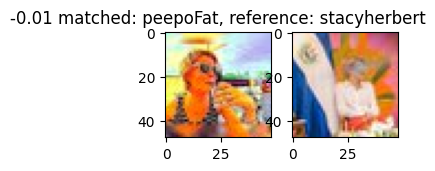

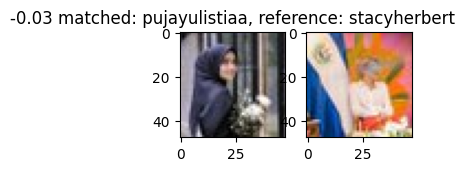

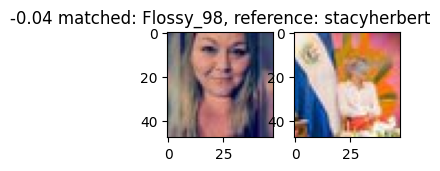

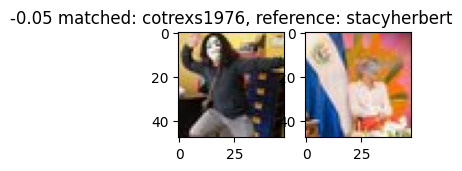

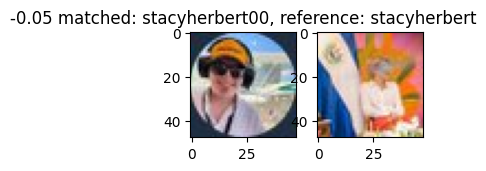

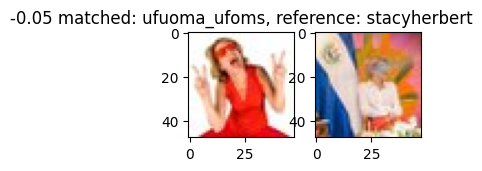

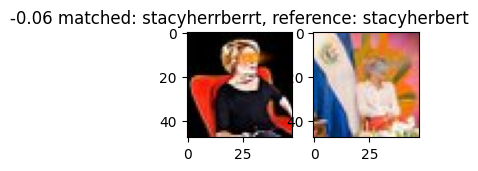

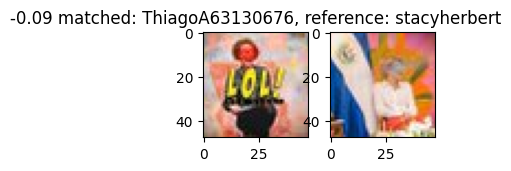

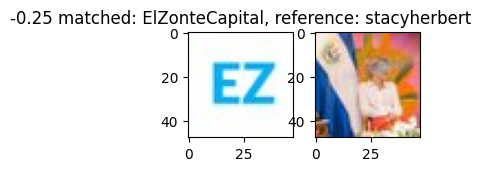

In [37]:
for n,row in df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(3,3))
    plt.subplot(121)
    plt.title(f'{row.sim_val:1.2f} matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.subplot(122)
    plt.imshow(reference_image)

In [43]:
th = 0.6
likely_matched_df = df[df.sim_val >= th].reset_index()
likely_matched_df

,index,screen_name,sim_val
0,19,staceey_herbert,0.998870
1,12,stacyherrbbertt,0.998870
2,26,Stacyherberi,0.998848
3,8,ReinaGraham18,0.998825
4,13,stacyherberrt__,0.998825
5,5,sStacyherbert_,0.940742


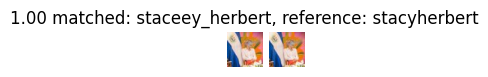

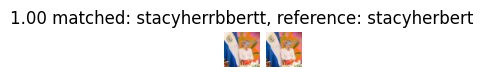

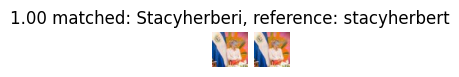

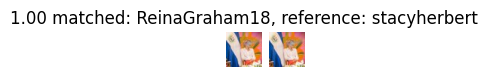

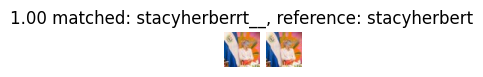

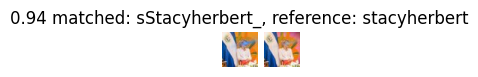

In [44]:
for n,row in likely_matched_df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(1,1))
    #plt.tight_layout()
    plt.subplot(121)
    plt.title(f'{row.sim_val:1.2f} matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(reference_image)
    plt.axis('off')
    

In [45]:
for n,row in likely_matched_df.iterrows():
    user = user_cache[row.screen_name]
    print(f'screen_name: {user.screen_name}\t,mean_diff:{row.sim_val:1.2f}, name:{user.name[:-5]}')
    url = f'https://twitter.com/{user.screen_name}'
    print(url)

screen_name: staceey_herbert	,mean_diff:1.00, name:Stacy He
https://twitter.com/staceey_herbert
screen_name: stacyherrbbertt	,mean_diff:1.00, name:Stacy Herbe
https://twitter.com/stacyherrbbertt
screen_name: Stacyherberi	,mean_diff:1.00, name:Stacy He
https://twitter.com/Stacyherberi
screen_name: ReinaGraham18	,mean_diff:1.00, name:@stacyhe
https://twitter.com/ReinaGraham18
screen_name: stacyherberrt__	,mean_diff:1.00, name:Stacy Herbe
https://twitter.com/stacyherberrt__
screen_name: sStacyherbert_	,mean_diff:0.94, name:Stacy Herbe
https://twitter.com/sStacyherbert_


In [46]:
for n,row in likely_matched_df.iterrows():
    user = user_cache[row.screen_name]
    url = f'https://twitter.com/{user.screen_name}'
    print(url)

https://twitter.com/staceey_herbert
https://twitter.com/stacyherrbbertt
https://twitter.com/Stacyherberi
https://twitter.com/ReinaGraham18
https://twitter.com/stacyherberrt__
https://twitter.com/sStacyherbert_
